<a href="https://colab.research.google.com/github/navicester/ml-docs/blob/master/Anomaly-Detection-in-Manufacturing/1.A_milling-data-exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of the UC Berkeley Milling Data Set
> In this notebook we introduce a metal machining data set. We’ll explore the data set and see how it is structured. Data exploration is an important first step in any new data science problem. (notebook originally featured at [tvhahn.com](https://www.tvhahn.com/), official GitHub repo: https://github.com/tvhahn/ml-tool-wear)

Let’s pretend that you're at a manufacturing company engaged in metal machining. You're an engineer working at this company, and the CEO has tasked you to develop a system to detect tool wear. Where to start? 

UC Berkeley created a milling data set in 2008, which you can download from the [NASA Prognostics Center of Excellence web page](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/). We’ll use this data set to try out some ideas. In this notebook we’ll briefly cover what milling is before exploring and visualizing the data set.

## Setup Notebook

The notebook can be run with google colab. Alternatively, clone the repo and run on your local machine. You'll need python 3.6+ with the following packages in your local environment:

* Numpy
* SciPy
* Pandas
* Matplotlib
* Seaborn

First, we will load all the neccessary packages.

In [1]:
import numpy as np
import scipy.io as sio # for reading matlab files
import pathlib
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

%matplotlib inline

Set the appropriate working folders.

In [2]:
# move into the root directory of 'Manufacturing-Data-Science-with-Python'
os.chdir('../')
root_dir = Path.cwd() # set the root directory as a Pathlib path

folder_raw_data = root_dir / 'Data Sets/milling_uc_berkeley/raw/' # raw data folder that holds the .zip .mat files for milling data
folder_processed_data = root_dir / 'Data Sets/milling_uc_berkeley/processed/' # processed data folder
working_folder = root_dir / 'Metal Machining' # working folder

We now need to prepare the notebook by downloading the milling data file and other important files. This needs to be done if you are running in google colab. If the repository has been cloned from github, then there is no need.

In [3]:
# if the the raw data folder does not exist, then you are likely
# in a google colab environment. In that case, we will create the 
# raw data and processed data folders and download the appropriate
# files
if folder_raw_data.exists() == False:

    pathlib.Path(folder_raw_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_raw_data)
    !wget 'https://github.com/tvhahn/Manufacturing-Data-Science-with-Python/raw/master/Data%20Sets/milling_uc_berkeley/raw/mill.zip'
    
    
if folder_processed_data.exists() == False:

    pathlib.Path(folder_processed_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_processed_data)
    !wget 'https://raw.githubusercontent.com/tvhahn/Manufacturing-Data-Science-with-Python/master/Data%20Sets/milling_uc_berkeley/processed/labels_with_tool_class.csv'

# if working folder does not exist, then create it
pathlib.Path(working_folder).mkdir(parents=True, exist_ok=True)
if (working_folder / 'data_prep.py').exists() == False:
    os.chdir(working_folder)   
    # download important python files into the 'Metal Machining' directory
    !wget 'https://raw.githubusercontent.com/tvhahn/Manufacturing-Data-Science-with-Python/master/Metal%20Machining/data_prep.py'

    
# extract mill.mat from the zip file
with zipfile.ZipFile(folder_raw_data / 'mill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)
    
os.chdir(working_folder)

--2023-03-05 03:58:47--  https://github.com/tvhahn/Manufacturing-Data-Science-with-Python/raw/master/Data%20Sets/milling_uc_berkeley/raw/mill.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tvhahn/Manufacturing-Data-Science-with-Python/master/Data%20Sets/milling_uc_berkeley/raw/mill.zip [following]
--2023-03-05 03:58:47--  https://raw.githubusercontent.com/tvhahn/Manufacturing-Data-Science-with-Python/master/Data%20Sets/milling_uc_berkeley/raw/mill.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15140674 (14M) [application/zip]
Saving to: ‘mill.zip’

mill.zip            100%[==========

# What is milling?

In milling, a rotary cutter removes material as it moves along a work piece. Most often, milling is performed on metal – it's metal machining – and that’s what is happening at the company you’re at.    

The picture below demonstrates a face milling procedure. The cutter is progressed forward while rotating. As the cutter rotates, the tool inserts “bite” into the metal and remove it.  

<br>
<div style="text-align: center; ">
<figure>
  <img src="https://github.com/tvhahn/Manufacturing-Data-Science-with-Python/blob/master/Metal%20Machining/images/face_milling.svg?raw=1" alt="milling tool cutting into metal" style="background:none; border:none; box-shadow:none; text-align:center" width="400px"/>
  <div style="text-align: center; ">
  <br>
  <figcaption style="color:grey; font-size:smaller"> A milling tool has serveral tool inserts on it. As the tool rotates, and is pushed forward, the inserts cut into the metal. (Image modified from <a href="https://commons.wikimedia.org/wiki/File:Fraisage_surfacage.svg#/media/File:Fraisage_surfacage.svg">Wikipedia</a>)</figcaption>
  </div>
</figure>
</div>

Over time, the tool inserts wear. Specifically, the flank of the tool wears, as shown below. In the UC Berkeley milling data set the flank wear (VB) is measured as the tool wears.

<div style="text-align: center; ">
<figure>
  <img src="https://github.com/tvhahn/Manufacturing-Data-Science-with-Python/blob/master/Metal%20Machining/images/flank_wear.svg?raw=1" alt="flank wear on tool insert" style="background:none; border:none; box-shadow:none; text-align:center" width="500px"/>
  <!-- <div style="text-align: left; "> -->
  <figcaption style="color:grey; font-size:smaller">Flank wear on a tool insert (perspective and front view). <i>VB</i> is the measure of flank wear. (Image from author)</figcaption>
  <!-- </div> -->
</figure>
</div>

# Data Exploration
Data exploration is the first important step when tackling any new data science problem. Where to begin? The first step is understanding how the data is structured. How is the data stored? In a database? In an array? Where is the meta-data (things like labels and time-stamps)?

## Data Structure
The UC Berkeley milling data set is contained in a structured MATLAB array. We can load the .mat file using the scipy.io module and the loadmat function.

In [4]:
os.chdir(working_folder) # make sure you're in the right folder

# load the data from the matlab file
m = sio.loadmat(folder_raw_data / 'mill.mat',struct_as_record=True)

The data is stored as a dictionary. Let's look to see what it is made of.

In [5]:
# show some of the info from the matlab file
print('Keys in the matlab dict file: \n', m.keys(), '\n')

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 



Only the 'mill' part of the dictionary contains useful information. We'll put that in a new numpy array called 'data.

In [6]:
# check to see what m['mill'] is
print(type(m['mill']))

# store the 'mill' data in a seperate np array
data = m['mill']

<class 'numpy.ndarray'>


We now want to see what the 'data' array is made up of.

In [7]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names
print('List of the field names:\n',l)

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


## Meta-Data

The documentation with the UC Berkeley milling data set contains additional information, and highlights information about the meta-data. The  data set is made of 16 cases of milling tools performing cuts in metal. Six cutting parameters were used in the creation of the data: 

* the metal type (either cast iron or steel, labelled as 1 or 2 in the data set, respectively)
* the depth of cut (either 0.75 mm or 1.5 mm)
* the feed rate (either 0.25 mm/rev or 0.5 mm/rev)

Each of the 16 cases is a combination of the cutting parameters (for example, case one has a depth of cut of 1.5 mm, a feed rate of 0.5 mm/rev, and is performed on cast iron). 

The cases are made up of individual cuts from when the tool is new to degraded or worn. There are 167 cuts (called 'runs' in the documentation) amongst all 16 cases. Many of the cuts are accompanied by a measure of flank wear (VB). We'll use this later to label the cuts as eigther healthy, degraded, or worn.

Finally, six signals were collected during each cut: acoustic emission (AE) signals from the spindle and table; vibration from the spindle and table; and AC/DC current from the spindle motor. The signals were collected at 250 Hz and each cut has 9000 sampling points, for a total signal length of 36 seconds.

We will extract the meta-data from the numpy array and store it as a pandas dataframe -- we'll call this dataframe `df_labels` since it contains the label information we'll be interested in. This is how we create the dataframe.

In [8]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []
    
    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]
    
# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


## Data Visualization

Visuallizing a new data set is a great way to get an understanding of what is going on, and detect any strange things going on. I also love data visualization, so we'll create a beautiful graphic using Seaborn and Matplotlib.

There are only 167 cuts in this data set, which isn't a huge amount. Thus, we can visually inspect each cut to find abnormalities. Fortunately, I've already done that for you.... Below is a highlight.

First, we'll look at a fairly "normal" cut -- cut number 167.

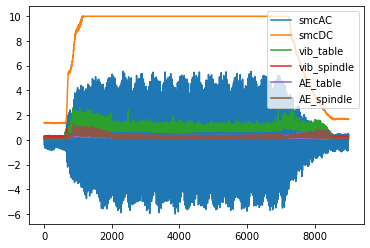

In [9]:
# look at cut number 167 (index 166)
cut_no = 166
fig, ax = plt.subplots()

ax.plot(data[0,cut_no]['smcAC'], label='smcAC')
ax.plot(data[0,cut_no]['smcDC'], label='smcDC')
ax.plot(data[0,cut_no]['vib_table'], label='vib_table')
ax.plot(data[0,cut_no]['vib_spindle'], label='vib_spindle')
ax.plot(data[0,cut_no]['AE_table'], label='AE_table')
ax.plot(data[0,cut_no]['AE_spindle'], label='AE_spindle')

plt.legend()

However, if you look at all the cuts, you'll find that cuts 18 and 95 (index 17 and 94) are off -- they will need to be discarded when we start building our anomaly detection model.

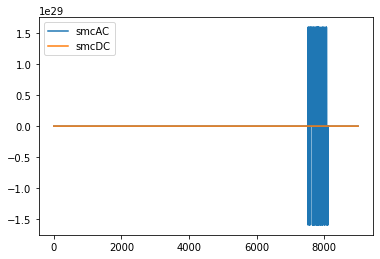

In [10]:
# plot cut no. 18 (index 17). Only plot current signals for simplicity.
cut_no = 17
fig, ax = plt.subplots()

ax.plot(data[0,cut_no]['smcAC'], label='smcAC')
ax.plot(data[0,cut_no]['smcDC'], label='smcDC')

plt.legend()

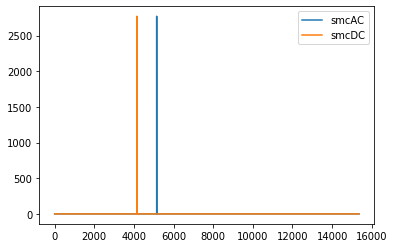

In [11]:
# plot cut no. 95 (index 94). Only plot current signals for simplicity.
cut_no = 94
fig, ax = plt.subplots()

ax.plot(data[0,cut_no]['smcAC'], label='smcAC')
ax.plot(data[0,cut_no]['smcDC'], label='smcDC')

plt.legend()

Cut 106 is also weird...

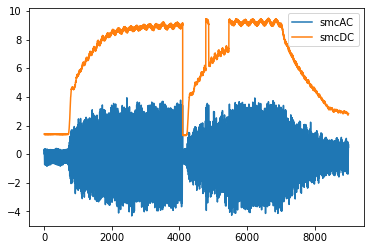

In [12]:
cut_no = 105
fig, ax = plt.subplots()

ax.plot(data[0,cut_no]['smcAC'], label='smcAC')
ax.plot(data[0,cut_no]['smcDC'], label='smcDC')

plt.legend()

Finally, we'll create a beautiful plot that nicely visualizes each of the six signals together.

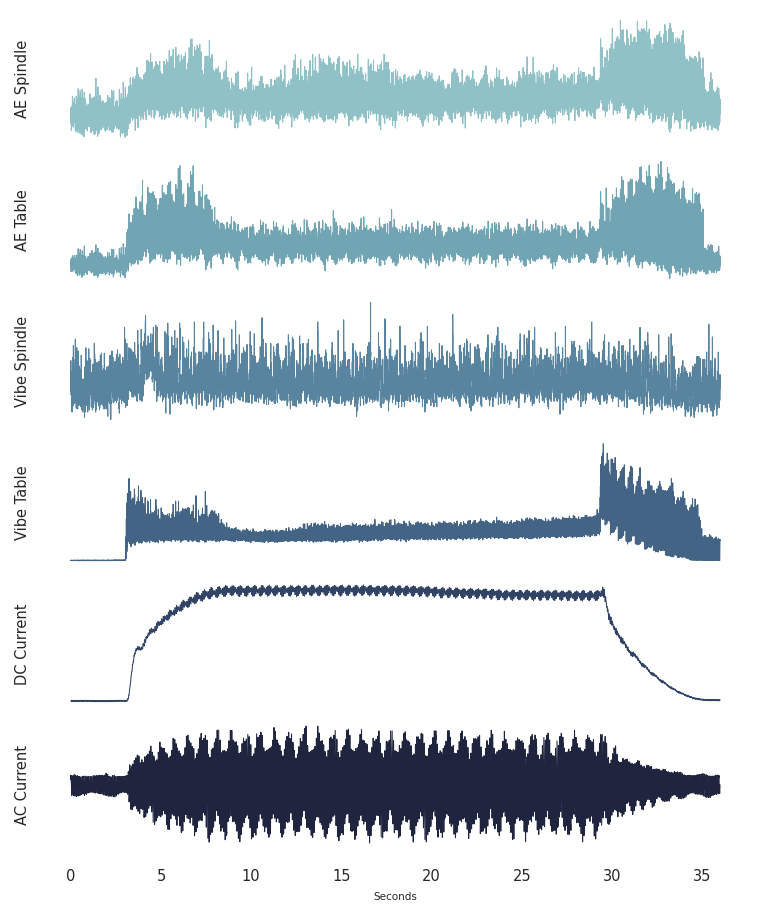

In [13]:
def plot_cut(cut_signal, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signal
        # note, we take the length of the signal (9000 data point)
        # and divide it by the frequency (250 Hz) to get the x-axis
        # into seconds
        axes[i].plot(np.arange(0,9000)/250.0, 
                     cut_signal[signals_trend[i]], 
                     color=pal[i], 
                     linewidth=0.5, 
                     alpha=1)
        
        axis_label = signal_names_revised[i]
        
        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal on the plot
        # we don't want to show the subplot outlines
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([]) # also remove the y-ticks, cause ugly
        
        # for the last signal we will show the x-axis labels
        # which are the length (in seconds) of the signal
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)
            axes[i].set_xlabel('Seconds', size=5)


signals_trend = list(l[7:])  # there are 6 types of signals, smcAC to AE_spindle
signals_trend = signals_trend[::-1]  # reverse the signal order so that it is matching other charts

# we'll plot signal 146 (index 145)
cut_signal = data[0, 145]

plot_cut(cut_signal, signals_trend, "cut_146")
# plt.savefig('cut_signals.png',format='png') # save the figure
plt.show()